In [ ]:
#%%

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# %%

#import rna data 
rna=pd.read_csv("/home/arianna/subtype_dl/rna_filtered.csv", sep='\t', index_col=0)
truth_label=pd.read_csv("/home/arianna/subtype_dl/truth_label", sep='\t')

#print(truth_label['CANCER_TYPE_DETAILED'].unique())

# Create a mapping of cancer types to numbers
cancer_type_mapping = {'Dedifferentiated Liposarcoma': 0,  
                      'Leiomyosarcoma': 1,
                      'Myxofibrosarcoma' : 2,
                      'Undifferentiated Pleomorphic Sarcoma' :3,
                      'Synovial Sarcoma': 4}

# Apply the mapping to the 'CANCER_TYPE_DETAILED' column
truth_label['CANCER_TYPE_CODE'] = truth_label['CANCER_TYPE_DETAILED'].map(cancer_type_mapping)

# Create a new DataFrame with the same index but with the corresponding number
truth_coded = truth_label[['CANCER_TYPE_CODE']]


print("truth label")
print(truth_label)



y_binarized = label_binarize(truth_coded.CANCER_TYPE_CODE, classes=[0, 1, 2, 3, 4])
truth_coded = truth_coded.values
# Flatten truth_coded properly
truth_coded = truth_coded.flatten()


print("truth coded")
print(truth_coded) #y

print("y binarized")
print(y_binarized)

print(rna.values)

print("types!")
print(type(rna.values))
print(type(truth_coded))
print(type(y_binarized))


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(rna.values, truth_coded, test_size=0.2, random_state=42)
y_train_binarized, y_test_binarized = train_test_split(y_binarized, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
x_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
x_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Convert to PyTorch tensors for ROC curve (binarized labels)
y_train_binarized = torch.tensor(y_train_binarized, dtype=torch.float32)
y_test_binarized = torch.tensor(y_test_binarized, dtype=torch.float32)

# Create TensorDataset
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

# Define batch size
batch_size = 122

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

truth label
           SAMPLE_ID                  CANCER_TYPE_DETAILED  CANCER_TYPE_CODE
0    TCGA-3B-A9HI-01          Dedifferentiated Liposarcoma                 0
1    TCGA-3B-A9HJ-01          Dedifferentiated Liposarcoma                 0
2    TCGA-3B-A9HL-01          Dedifferentiated Liposarcoma                 0
3    TCGA-3B-A9HO-01          Dedifferentiated Liposarcoma                 0
4    TCGA-3B-A9HP-01                        Leiomyosarcoma                 1
..               ...                                   ...               ...
237  TCGA-X9-A971-01                        Leiomyosarcoma                 1
238  TCGA-X9-A973-01  Undifferentiated Pleomorphic Sarcoma                 3
239  TCGA-Z4-A9VC-01          Dedifferentiated Liposarcoma                 0
240  TCGA-Z4-AAPF-01                      Synovial Sarcoma                 4
241  TCGA-Z4-AAPG-01  Undifferentiated Pleomorphic Sarcoma                 3

[242 rows x 3 columns]
truth coded
[0 0 0 0 1 1 1 1 1 1 1 1 1 1

In [ ]:
# %%

#################################
#DEFINE THE NETWORK MODEL
##################################

class MultiClassModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MultiClassModel, self).__init__()
        self.linear1 = nn.Linear(input_size, 64)
        self.linear2 = nn.Linear(64, 128)
        self.linear3 = nn.Linear(128, 96)
        self.linear4 = nn.Linear(96, 32)
        self.linear5 = nn.Linear(32, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.relu(self.linear2(x))
        x = self.dropout(x)
        x = self.relu(self.linear3(x))
        x = self.dropout(x)
        x = self.relu(self.linear4(x))
        x = self.linear5(x)  # Output logits for each class
        return x

# Define input size and number of classes
input_size = X_train.shape[1]
num_classes = len(np.unique(truth_coded))

# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiClassModel(input_size, num_classes).to(device)

In [ ]:
# %%

###############################
#DEFINE LOSS FUNCTION AND OPTIMIZER 
################################

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# %%

###############################
#TRAINING AND EVALUATION LOOP WITH ROC CURVE
###############################

# Training loop
epochs = 100

# Lists to store results
epoch_count = []
train_loss_values = []
test_loss_values = []

# Training and evaluation loop
for epoch in range(epochs):

    # Training mode
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = 100.0 * correct_train / total_train

    # Evaluation mode
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    all_targets = []
    all_outputs = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == targets).sum().item()
            total_test += targets.size(0)
            
            all_targets.extend(targets.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = 100.0 * correct_test / total_test

    # Print progress every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:4} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}% | Validation Loss: {test_loss:.4f} | Validation Accuracy: {test_accuracy:.2f}%')

    # Append values to lists for plotting
    epoch_count.append(epoch)
    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)

Epoch:    0 | Train Loss: 1.6033 | Train Accuracy: 23.83% | Validation Loss: 1.4446 | Validation Accuracy: 57.14%
Epoch:   10 | Train Loss: 0.3006 | Train Accuracy: 86.53% | Validation Loss: 1.3576 | Validation Accuracy: 73.47%
Epoch:   20 | Train Loss: 0.0575 | Train Accuracy: 98.96% | Validation Loss: 2.0063 | Validation Accuracy: 75.51%
Epoch:   30 | Train Loss: 0.0562 | Train Accuracy: 97.93% | Validation Loss: 2.9179 | Validation Accuracy: 71.43%
Epoch:   40 | Train Loss: 0.0021 | Train Accuracy: 100.00% | Validation Loss: 2.6620 | Validation Accuracy: 73.47%
Epoch:   50 | Train Loss: 0.0268 | Train Accuracy: 98.96% | Validation Loss: 2.3976 | Validation Accuracy: 73.47%
Epoch:   60 | Train Loss: 0.0591 | Train Accuracy: 99.48% | Validation Loss: 3.1311 | Validation Accuracy: 69.39%
Epoch:   70 | Train Loss: 0.0007 | Train Accuracy: 100.00% | Validation Loss: 3.1920 | Validation Accuracy: 73.47%
Epoch:   80 | Train Loss: 0.0013 | Train Accuracy: 100.00% | Validation Loss: 3.2071 |

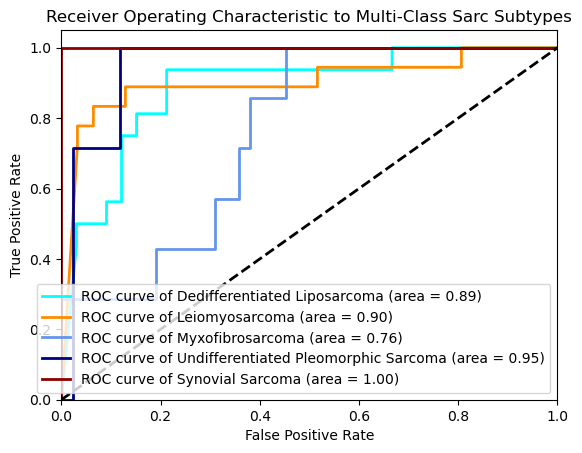

In [ ]:
#%%

#############################
# PLOT
##############################

# ROC Curve Calculation and Plotting
all_targets = np.array(all_targets)
all_outputs = np.array(all_outputs)
all_outputs_prob = torch.softmax(torch.tensor(all_outputs), dim=1).numpy()

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], all_outputs_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'navy', 'darkred']

cancer_type_mapping = {
    0: 'Dedifferentiated Liposarcoma',
    1: 'Leiomyosarcoma',
    2: 'Myxofibrosarcoma',
    3: 'Undifferentiated Pleomorphic Sarcoma',
    4: 'Synovial Sarcoma'
}

for i, color in zip(range(len(cancer_type_mapping)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(cancer_type_mapping[i], roc_auc[i]))


#for i, color in zip(range(num_classes), colors):
#    plt.plot(fpr[i], tpr[i], color=color, lw=2,
#             label='ROC curve of class {0} (area = {1:0.2f})'
#             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic to Multi-Class Sarc Subtypes')
plt.legend(loc="lower right")
plt.savefig('/home/arianna/subtype_dl/roc_curve_multiclass.pdf', format='pdf', dpi=300)
plt.show()

[0 1 1 3 1 3 1 1 1 0 1 0 1 0 2 1 3 1 1 0 0 0 0 3 1 1 1 0 1 1 1 0 0 0 0 3 3
 0 0 0 2 0 3 1 1 1 1 0 4]
Accuracy: 75.51%


<Figure size 1000x800 with 0 Axes>

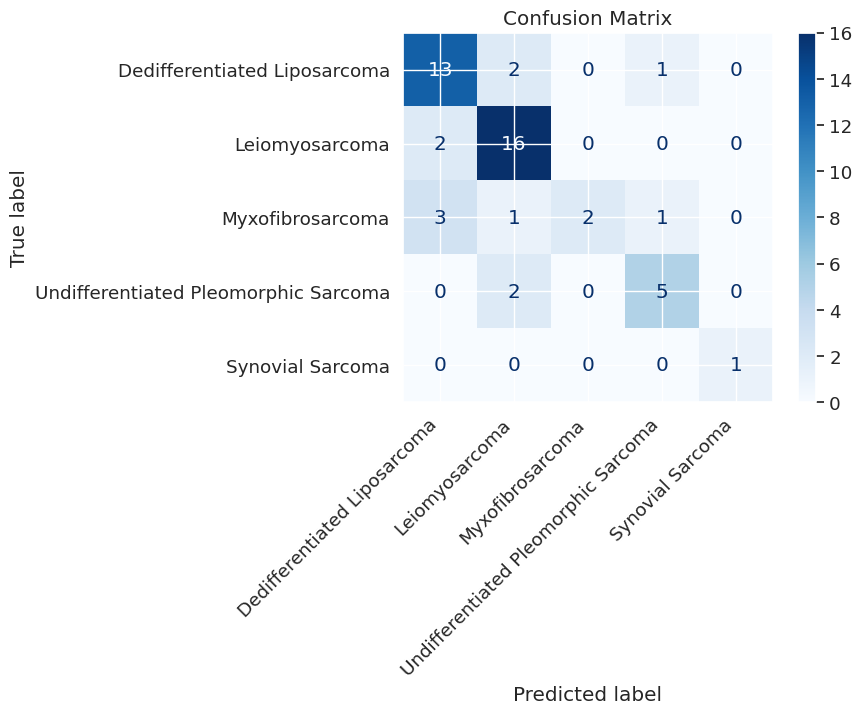

In [ ]:
# %%

######################################
#CALCULATE ACCURACY AND PLOT CONFUSIUON MATRIX
######################################

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
import numpy as np
import torch

# Assuming you have:
# - all_targets: list of true labels (0, 1, 2, 3, 4) for each subtype
# - all_outputs: list of raw logits from your model (before softmax)
# - y_test_binarized: binarized labels obtained from label_binarize

# Convert outputs to probabilities
all_outputs = np.array(all_outputs)
all_outputs_prob = torch.softmax(torch.tensor(all_outputs), dim=1).numpy()

# Get predicted class labels
y_pred = np.argmax(all_outputs_prob, axis=1)

print(y_pred)


#---------------
#ACCURACY

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred) * 100
print(f"Accuracy: {accuracy:.2f}%")

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

#------------------
#CONFUSION MATRIX

# Plot the confusion matrix 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Class labels (replace with your actual class names)
class_names = ['Dedifferentiated Liposarcoma', 'Leiomyosarcoma',  'Myxofibrosarcoma',
           'Undifferentiated Pleomorphic Sarcoma', 'Synovial Sarcoma']

# Plot the confusion matrix using seaborn with custom settings
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.set_theme(font_scale=1.2)  # Adjust font size for readability
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cmd.plot(cmap='Blues', values_format='d')  # Use 'Blues' colormap and integer format for values
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.savefig('/home/arianna/subtype_dl/conf_matrix_multiclass.pdf', format='pdf', dpi=300)
plt.show()